In [1]:
import wikipedia as wp
import numpy as np 
import pandas as pd 
import json
from geopy.geocoders import Nominatim
import requests
import sklearn
from pandas.io.json import json_normalize  #transfor json to pd dataframe

import matplotlib.cm as cm 
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium

print  ('Libraries Imported!')



Libraries Imported!


In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [4]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'Y3V24FUVVQP04I1UM02QYAPYC4XDGW5JHT3OYB1V3G3UZDAT' # your Foursquare ID
    CLIENT_SECRET = 'LJZUBUGOVPQNJKFPJ2STZ3GCZAWEORZPNJWPNEFETEAQGOBP' # your Foursquare Secret
    VERSION = '20180604'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [5]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'Y3V24FUVVQP04I1UM02QYAPYC4XDGW5JHT3OYB1V3G3UZDAT' # your Foursquare ID
    CLIENT_SECRET = 'LJZUBUGOVPQNJKFPJ2STZ3GCZAWEORZPNJWPNEFETEAQGOBP' # your Foursquare Secret
    VERSION = '20180604'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [6]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [9]:

# get new york data
new_york_data=get_new_york_data()
new_york_data.head()


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [11]:
new_york_data.shape

(306, 4)

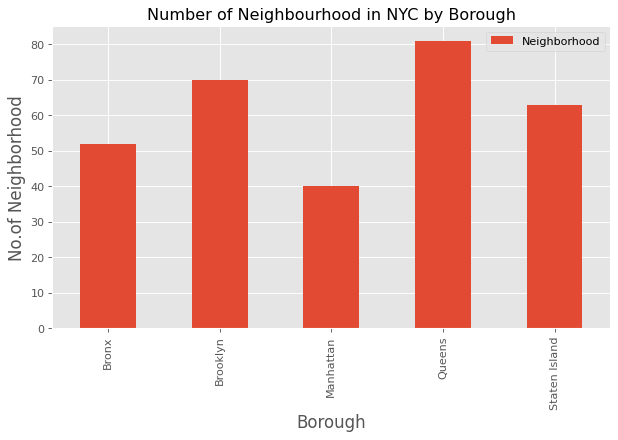

In [12]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighbourhood in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()


In [13]:
# prepare neighborhood list that contains indian restaurant
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

In [14]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


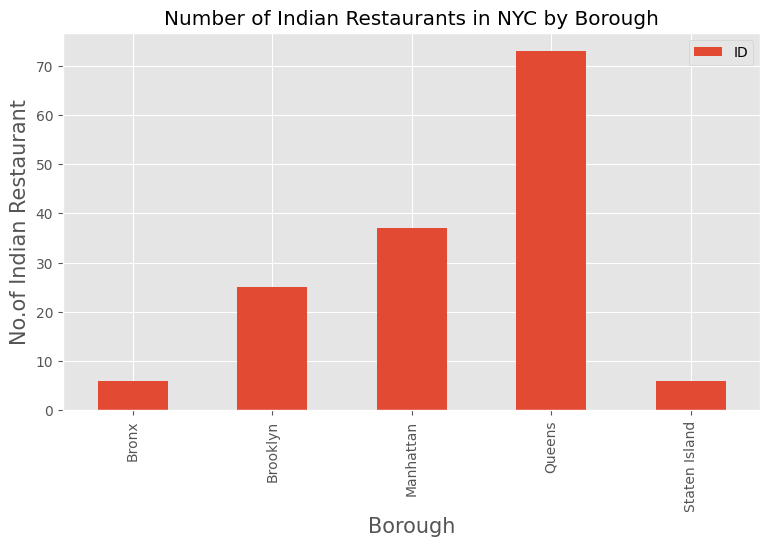

In [15]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurant', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [16]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.9    10
( 1 / 147 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.1     2
( 2 / 147 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     5.8     9
( 3 / 147 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     7.1     3
( 4 / 147 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.1     2
( 5 / 147 ) processed
                         ID       Name  Likes  Rating  Tips
0  4b5a4dc8f964a520a2bb28e3  Taj Mahal     37     7.9    26
( 6 / 147 ) processed
                         ID          Name  Likes

In [17]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.9,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.1,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.8,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.1,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.1,2


In [18]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [19]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Brooklyn,6.552000
0,Bronx,5.500000
2,Manhattan,5.367568
3,Queens,0.000000
4,Staten Island,0.000000


In [21]:
# Restaurants with maximum Likes
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                600
Rating                                 9
Tips                                 150
Name: 42, dtype: object

In [22]:
# Restaurants with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood           Greenwich Village
ID              5b5a2c9e66f3cd002ca0aab5
Name                      Bombay Bistros
Likes                                 31
Rating                                 9
Tips                                   6
Name: 41, dtype: object

In [23]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [24]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
29,Greenwich Village,9.00
67,Tribeca,9.00
72,West Village,8.95
49,Prospect Heights,8.90
50,Prospect Lefferts Gardens,8.70
10,Chelsea,8.70
70,Upper West Side,8.55
45,North Side,8.50
60,South Side,8.50
22,Fort Greene,8.50


In [26]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [27]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [28]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Neighborhood,Latitude,Longitude,Average Rating
6,Manhattan,Greenwich Village,40.726933,-73.999914,9.00
15,Manhattan,Tribeca,40.721522,-74.010683,9.00
18,Manhattan,West Village,40.734434,-74.006180,8.95
11,Brooklyn,Prospect Heights,40.676822,-73.964859,8.90
2,Staten Island,Chelsea,40.594726,-74.189560,8.70
1,Manhattan,Chelsea,40.744035,-74.003116,8.70
12,Brooklyn,Prospect Lefferts Gardens,40.658420,-73.954899,8.70
16,Manhattan,Upper West Side,40.787658,-73.977059,8.55
10,Brooklyn,North Side,40.714823,-73.958809,8.50
5,Brooklyn,Fort Greene,40.688527,-73.972906,8.50


In [29]:

# create map and display it
ny_map = folium.Map(location=(40.693943, -73.985880), zoom_start=12)


In [30]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )


In [31]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'